# X Inactivation

I'd like to explore the state of genes on the X chromosome and see to what degree
the iPSCs reactivate their inactive Xs.

In [529]:
import glob
import os
import random
import subprocess

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

import cardipspy as cpy
import ciepy

%matplotlib inline

In [2]:
import socket
if socket.gethostname() == 'fl1':
    pbt.set_tempdir('/projects/cdeboever/pybedtools_temp')

In [4]:
outdir = os.path.join(ciepy.root, 'output',
                      'x_inactivation')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'x_inactivation')
cpy.makedir(private_outdir)

In [394]:
sns.set_style('whitegrid')

In [24]:
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rsem_tpm.tsv')
tpm = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv')
rna_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv')
subject_meta = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv')
wgs_meta = pd.read_table(fn, index_col=0)

gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)

genes = pbt.BedTool(cpy.gencode_gene_bed)

In [6]:
locus_fns = glob.glob(os.path.join(ciepy.root, 'output', 'input_data', 'mbased_locus',
                                   '*_locus.tsv'))
snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

In [7]:
locus_res = {}
for fn in locus_fns:
    locus_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

locus_p = pd.Panel(locus_res)
snv_p = pd.Panel(snv_res)

In [51]:
sf = subject_meta[subject_meta.sex == 'F']
meta = sf.merge(rna_meta, left_index=True, right_on='subject_id')
meta = meta.ix[[x for x in snv_p.items if x in meta.index]]

In [95]:
locus_p = locus_p.ix[meta.index]
snv_p = snv_p.ix[meta.index]

In [273]:
# Filter  and take log.
tpm_f = tpm[(tpm != 0).sum(axis=1) > 0]
log_tpm = np.log10(tpm_f + 1)
# Mean center.
log_tpm_c = (log_tpm.T - log_tpm.mean(axis=1)).T
# Variance normalize.
log_tpm_n = (log_tpm_c.T / log_tpm_c.std(axis=1)).T

## Individual Sample

Let's take a look at one sample.

In [899]:
df = locus_res[meta.index[0]]
x = df[gene_info.ix[df.index, 'chrom'] == 'chrX']
notx = df[gene_info.ix[df.index, 'chrom'] != 'chrX']

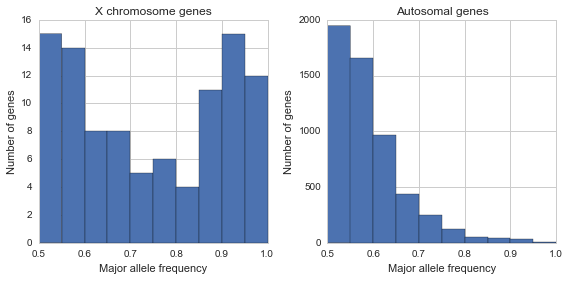

In [905]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
x.major_allele_freq.hist(ax=ax, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
ax = axs[1]
notx.major_allele_freq.hist(ax=ax, bins=np.arange(0.5, 1.05, 0.05))
ax.set_xlim(0.5, 1)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('Major allele frequency')
plt.tight_layout();
#plt.savefig(os.path.join(outdir, 'single_sample_majaf.pdf'))

This figure shows the distribution of gene major allele frequencies for
genes on the X chromosome and for genes on the autosomes. We can see that
autosomal genes often have a MajAF near 50% with few genes near 100%. However,
many X chromosome genes are near 100%. These genes are likely still inactivated.

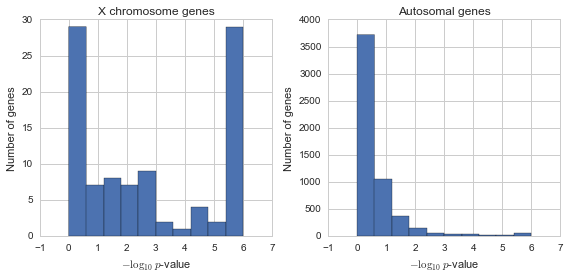

In [397]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
(-np.log10(x.p_val_ase + x.p_val_ase[x.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('X chromosome genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
ax = axs[1]
(-np.log10(notx.p_val_ase + notx.p_val_ase[notx.p_val_ase != 0].min())).hist(ax=ax)
ax.set_title('Autosomal genes')
ax.set_ylabel('Number of genes')
ax.set_xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout();

We can see that the X chromosome is enriched for genes with strong ASE
likely due to incomplete X reactivation.

## All Samples

Let's take a look at all female samples.

In [908]:
t = locus_p.ix[:, :, 'major_allele_freq']
x = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
notx = t.ix[set(t.index) & set(gene_info[gene_info.chrom != 'chrX'].index)]

In [909]:
sns.set_context('poster')

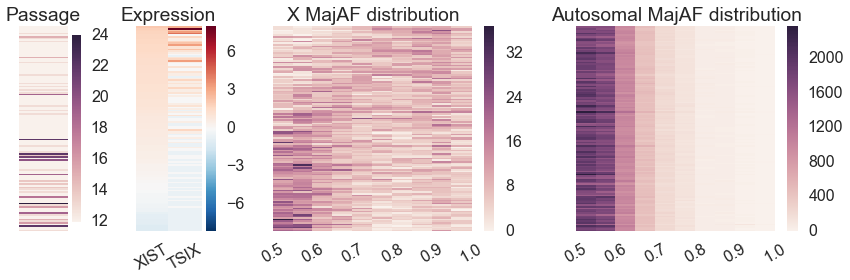

In [922]:
exp = log_tpm_n.ix[[gene_info[gene_info.gene_name == 'XIST'].index[0], 
                    gene_info[gene_info.gene_name == 'TSIX'].index[0]]].T
exp.columns = ['XIST', 'TSIX']
exp = exp.ix[x.columns].sort(columns='XIST', ascending=False)

fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[0.75, 1, 3, 3])

ax = plt.subplot(gs[0])
sns.heatmap(np.array([meta.ix[exp.index, 'passage'].values]).T, 
            xticklabels=False, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Passage')

ax = plt.subplot(gs[1])
sns.heatmap(exp, yticklabels=False, ax=ax)
ax.set_ylabel('')
ax.set_title('Expression')
for t in ax.get_xticklabels():
    t.set_rotation(30)

ax = plt.subplot(gs[2])
r = x.apply(lambda z: pd.cut(z[z.isnull() == False], bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
ax.set_title('X MajAF distribution')

ax = plt.subplot(gs[3])
r = notx.apply(lambda z: pd.cut(z[z.isnull() == False], bins=np.arange(0.5, 1.05, 0.05)))
r = r.apply(lambda z: z.value_counts())
sns.heatmap(r.ix[exp.index], yticklabels=False, ax=ax)
xmin,xmax = ax.get_xlim()
ax.set_xticks(np.arange(xmin, xmax + 1, 2))
ax.set_xticklabels(np.arange(0.5, 1.05, 0.1), rotation=30)
ax.set_ylabel('')
ax.set_title('Autosomal MajAF distribution')

gs.tight_layout(fig)
fig.savefig(os.path.join(outdir, 'x_reactivation_heatmap.png'), dpi=600)

These heatmaps are all aligned by row (so the first row across all heatmaps
is the same sample, the second row across all heatmaps is the same sample, etc.).
The heatmaps are ordered by each sample's XIST expression (shown in the second heatmap).
The X MajAF distribution heatmap is the same as the histogram above for one sample
but now we are stacking up the histograms for all samples. We can see that many
samples have genes that are inactive although the amount of inactivation varies
between samples and is highly correlated with XIST.

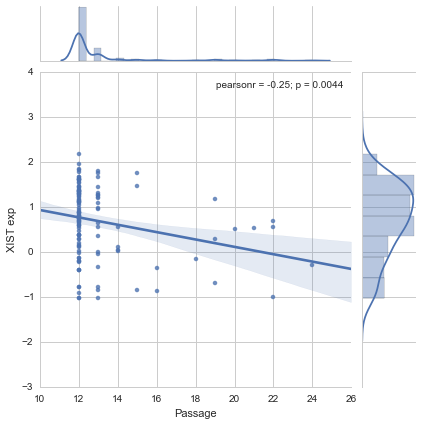

In [405]:
d = pd.DataFrame({'Passage':meta.passage, 
                  'XIST exp':log_tpm_n.ix[gene_info[gene_info.gene_name == 'XIST'].index[0], meta.index].T})
sns.jointplot(x='Passage', y='XIST exp', data=d, kind='reg');

The X chromosome is clearly enriched for having ASE which is probably due
to incomplete X reactivation. This may be related to passage. 

Are reactivated genes expressed more highly?

In [ ]:
from scipy.stats import ks_2samp

In [873]:
t = locus_p.ix[:, :, 'major_allele_freq']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]

In [874]:
pvals = []
for i in set(log_tpm_n.index) & set(t.index):
    se = t.ix[i]
    se = se[se.isnull() == False]
    a = log_tpm_n.ix[i, se[se >= 0.75].index]
    b = log_tpm_n.ix[i, se[se < 0.75].index]
    k,p = ks_2samp(a, b)
    if not np.isnan(p):
        pvals.append(p)
pvals = pd.Series(pvals)

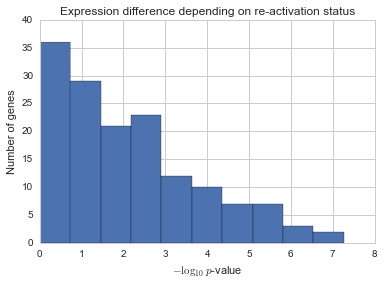

In [877]:
(-np.log10(pvals)).hist()
plt.ylabel('Number of genes')
plt.xlabel('$-\log_{10}$ $p$-value')
plt.title('Expression difference depending on re-activation status');

Only some genes show residual 
inactivation. Are these the same genes across samples?

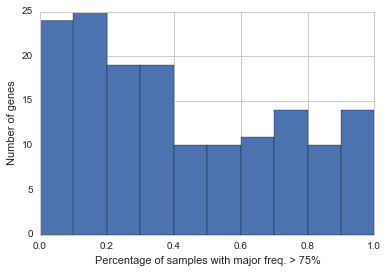

In [849]:
t = locus_p.ix[:, :, 'major_allele_freq']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
freq = (t[t.isnull() == False] > 0.75).sum(axis=1) / (t.isnull() == False).sum(axis=1)

freq.hist()
plt.ylabel('Number of genes')
plt.xlabel('Percentage of samples with major freq. > 75%');

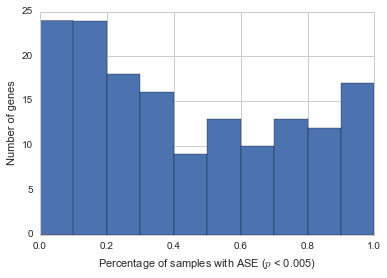

In [850]:
t = locus_p.ix[:, :, 'p_val_ase']
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
t = t[t.isnull().sum(axis=1) <= 0.8 * t.shape[1]]
freq = (t[t.isnull() == False] < 0.005).sum(axis=1) / (t.isnull() == False).sum(axis=1)

freq.hist()
plt.ylabel('Number of genes')
plt.xlabel('Percentage of samples with ASE ($p$ < 0.005)');

The above histograms show what percentage of samples have major
allele frequency greater than 75% for each gene or were significant
for ASE. Note that a gene in a sample is
included here only if it was tested by MBASED for ASE. I restricted to
genes that were tested by MBASED in at least 20% of the samples.

## Predicting Reactivation

I'd like to build a model that predicts whether reactivation occurs.
I could use the major allele frequency or significant ASE. If I use
significant ASE I can build a logisitic model. I should look into the
X inactivation literature but I imagine some relevant features could be:

* replication timing 
* distance from centromere or telomere 
* XIST binding motif density (does it have a binding motif?)
* distance from X inactivation center
* XIST expression
* TSIX expression

In [798]:
tm = meta.ix[t.columns]
tm = tm.sort(columns='in_eqtl', ascending=False)
tm = tm.drop_duplicates(subset='subject_id')

t = locus_p.ix[tm.index, :, 'p_val_ase']
t.index.name = 'gene_id'
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
features = pd.DataFrame(t.stack(), columns=['pvalue'])

t = locus_p.ix[tm.index, :, 'major_allele_freq']
t.index.name = 'gene_id'
t = t.ix[set(t.index) & set(gene_info[gene_info.chrom == 'chrX'].index)]
tt = pd.DataFrame(t.stack(), columns=['major_allele_freq'])
features.ix[tt.index, 'major_allele_freq'] = tt.major_allele_freq

features = features.reset_index()
features['sig'] = features.pvalue < 0.005
features['pos'] = (gene_info.ix[features.gene_id, ['start', 'end']].sum(axis=1) / 2).values
features['pos'] = features['pos'] - features['pos'].min()
features['intercept'] = 1

In [666]:
rt = pd.read_table('/raid3/publicdata/replication_domain_db/RD_sm300_2936763_hFibiPS4p72.hg19.txt',
                   low_memory=False, skiprows=15, index_col=0)
rt = rt[rt.Chromosome == 'chrX']
s = '\n'.join(rt.Chromosome + '\t' + rt.Start_Position.astype(str) + 
              '\t' + rt.End_Position.astype(str) + '\t' + 
              rt.Data_Value.astype(str)) + '\n'
rt_bt = pbt.BedTool(s, from_string=True)
rt_bt = rt_bt.sort()

res = genes.intersect(rt_bt, sorted=True, wo=True)
res = res.to_dataframe()
gb = res[['name', 'blockCount']].groupby('name').mean()
gb.columns = ['replication_timing']

res = genes.closest(rt_bt, sorted=True)
res = res.to_dataframe()
res = res[res.chrom == 'chrX']
res['blockCount'] = res['blockCount'].astype(float)
gb2 = res[['name', 'blockCount']].groupby('name').mean()
gb2.columns = ['replication_timing']
gb2 = gb2.drop(gb.index)

rt_x = pd.concat([gb, gb2])
features['replication_timing'] = rt_x.ix[features.gene_id, 'replication_timing'].values

In [750]:
d = pd.get_dummies(features['id'])
f = features[['replication_timing', 'intercept']].join(d.ix[:, 1:])

logit = sm.Logit(endog=features.sig, 
                 exog=f)
logit_result = logit.fit()
logit_result.summary()

Optimization terminated successfully.
         Current function value: 0.639198
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sig   No. Observations:                 9162
Model:                          Logit   Df Residuals:                     9054
Method:                           MLE   Df Model:                          107
Date:                Mon, 02 Nov 2015   Pseudo R-squ.:                 0.06823
Time:                        06:26:15   Log-Likelihood:                -5856.3
converged:                       True   LL-Null:                       -6285.1
                                        LLR p-value:                1.792e-117
========================================================================================================
                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
replication_timing                       0.0813      0.029      2.840      0.005         0.025     0.137
intercept                               -0.0733      0.204     -0.360      0.719        -0.473     0.326
076c5de8-b46f-4a1a-aa3a-ad91351eadc1     0.0262      0.314      0.083      0.934        -0.590     0.643
083eedd6-c1a9-4423-94e2-60ddf39db242    -0.3188      0.298     -1.068      0.285        -0.904     0.266
08d4ab09-9752-4285-9d0d-60530ebf8f45     0.0588      0.322      0.183      0.855        -0.572     0.689
10b64344-0a53-43cc-94f2-3564e3ac8ee7     0.2673      0.302      0.885      0.376        -0.325     0.859
17d0cf06-165a-4603-85c9-e7757d53094d     0.4638      0.306      1.516      0.129        -0.136     1.063
180a1096-66eb-4bc8-937a-117dc51af4bf     1.1041      0.352      3.132      0.002         0.413     1.795
1aa9a626-66b9-45cc-a7d3-7f40062f917d    -0.0513      0.280     -0.183      0.854        -0.600     0.497
1b445672-eb32-443d-92f2-f186ae09db8a    -0.4750      0.297     -1.596      0.110        -1.058     0.108
1c769c90-dafa-403e-8cc6-69406f664f88    -0.4283      0.313     -1.367      0.171        -1.042     0.186
1d040183-856b-4510-a6a2-9eef729bfc45     0.7694      0.315      2.440      0.015         0.151     1.387
1d2d5dff-3445-444a-acd6-ce5c58ab0dbc     0.3332      0.280      1.191      0.234        -0.215     0.882
1d39387d-681a-4576-a921-8db18c31de3e    -0.5172      0.328     -1.577      0.115        -1.160     0.126
21f70c19-d892-497c-80d7-c882eb4a1c84    -0.4855      0.321     -1.511      0.131        -1.115     0.144
24259405-4f4a-4769-9113-aec610bc31bd    -1.1387      0.318     -3.586      0.000        -1.761    -0.516
26f7236b-3334-494c-be8c-5b0ce3896423    -0.3228      0.290     -1.113      0.266        -0.891     0.245
27b1494c-3ac4-4778-901c-03acd0ee8df5     0.8409      0.314      2.680      0.007         0.226     1.456
2a7635ca-c7f8-4af6-b94b-cef1eff7d85d     0.0298      0.273      0.109      0.913        -0.505     0.565
2ac88937-6b3a-4cb4-84f2-71f57831535a    -1.6321      0.333     -4.894      0.000        -2.286    -0.979
2c2ff9ff-8464-432a-9de2-817ae7c5e838    -0.3453      0.278     -1.243      0.214        -0.890     0.199
2ebdb032-9c1b-4f38-b164-af5a39dd675d    -0.9140      0.301     -3.032      0.002        -1.505    -0.323
302eff2d-9979-47ab-8583-042358e069bd    -0.7461      0.295     -2.532      0.011        -1.324    -0.168
3202f6eb-f06d-4cb2-82e4-ff43815d3907     0.4281      0.292      1.464      0.143        -0.145     1.001
331f9a4a-7143-497b-a0fd-16863c82585a    -0.1475      0.269     -0.549      0.583        -0.675     0.380
349de0b8-ea4a-45eb-9631-8259b539f7b8     0.7120      0.325      2.190      0.028         0.075     1.349
36d16f69-733f-429c-b965-c2055637af9d     0.3362      0.313      1.074      0.283        -0.277     0.950
38b6cc3f-5c22-4f32-ab1a-b8c1d9232799     0.4808      0.297      1.616      0.106        -0.

In [764]:
d = pd.get_dummies(features['id'])
f = features[['replication_timing', 'pos', 'intercept']].join(d.ix[:, 1:])

logit = sm.Logit(endog=features.sig, 
                 exog=f)
logit_result = logit.fit()
logit_result.summary()

Optimization terminated successfully.
         Current function value: 0.632207
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sig   No. Observations:                 9162
Model:                          Logit   Df Residuals:                     9053
Method:                           MLE   Df Model:                          108
Date:                Mon, 02 Nov 2015   Pseudo R-squ.:                 0.07842
Time:                        08:46:18   Log-Likelihood:                -5792.3
converged:                       True   LL-Null:                       -6285.1
                                        LLR p-value:                1.214e-141
========================================================================================================
                                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------
replication_timing                       0.1322      0.029      4.525      0.000         0.075     0.189
pos                                   5.288e-09    4.7e-10     11.245      0.000      4.37e-09  6.21e-09
intercept                               -0.5459      0.210     -2.599      0.009        -0.958    -0.134
076c5de8-b46f-4a1a-aa3a-ad91351eadc1     0.1470      0.317      0.463      0.643        -0.475     0.769
083eedd6-c1a9-4423-94e2-60ddf39db242    -0.2979      0.301     -0.989      0.323        -0.888     0.292
08d4ab09-9752-4285-9d0d-60530ebf8f45     0.1397      0.325      0.430      0.667        -0.497     0.776
10b64344-0a53-43cc-94f2-3564e3ac8ee7     0.3097      0.305      1.016      0.309        -0.288     0.907
17d0cf06-165a-4603-85c9-e7757d53094d     0.4846      0.309      1.571      0.116        -0.120     1.089
180a1096-66eb-4bc8-937a-117dc51af4bf     1.1950      0.355      3.364      0.001         0.499     1.891
1aa9a626-66b9-45cc-a7d3-7f40062f917d    -0.0154      0.282     -0.055      0.956        -0.569     0.538
1b445672-eb32-443d-92f2-f186ae09db8a    -0.4194      0.300     -1.398      0.162        -1.008     0.169
1c769c90-dafa-403e-8cc6-69406f664f88    -0.3957      0.316     -1.253      0.210        -1.015     0.223
1d040183-856b-4510-a6a2-9eef729bfc45     0.8096      0.318      2.546      0.011         0.186     1.433
1d2d5dff-3445-444a-acd6-ce5c58ab0dbc     0.3586      0.282      1.271      0.204        -0.194     0.912
1d39387d-681a-4576-a921-8db18c31de3e    -0.4442      0.331     -1.343      0.179        -1.093     0.204
21f70c19-d892-497c-80d7-c882eb4a1c84    -0.3749      0.324     -1.157      0.247        -1.010     0.260
24259405-4f4a-4769-9113-aec610bc31bd    -1.0953      0.320     -3.425      0.001        -1.722    -0.468
26f7236b-3334-494c-be8c-5b0ce3896423    -0.3299      0.293     -1.128      0.259        -0.903     0.243
27b1494c-3ac4-4778-901c-03acd0ee8df5     0.9065      0.316      2.866      0.004         0.287     1.526
2a7635ca-c7f8-4af6-b94b-cef1eff7d85d    -0.0269      0.276     -0.097      0.922        -0.567     0.513
2ac88937-6b3a-4cb4-84f2-71f57831535a    -1.6487      0.336     -4.912      0.000        -2.307    -0.991
2c2ff9ff-8464-432a-9de2-817ae7c5e838    -0.3025      0.280     -1.080      0.280        -0.851     0.246
2ebdb032-9c1b-4f38-b164-af5a39dd675d    -0.9421      0.304     -3.101      0.002        -1.538    -0.347
302eff2d-9979-47ab-8583-042358e069bd    -0.6965      0.297     -2.344      0.019        -1.279    -0.114
3202f6eb-f06d-4cb2-82e4-ff43815d3907     0.4903      0.295      1.661      0.097        -0.088     1.069
331f9a4a-7143-497b-a0fd-16863c82585a    -0.1616      0.271     -0.596      0.551        -0.693     0.370
349de0b8-ea4a-45eb-9631-8259b539f7b8     0.7166      0.328      2.184      0.029         0.074     1.360
36d16f69-733f-429c-b965-c2055637af9d     0.4048      0.316      1.281      0.200        -0.

In [801]:
keys = sorted(set(features.pos))
se = pd.Series(range(len(keys)), index=keys)
features['pos_norm'] = se[features.pos].values

In [802]:
features.head()

,gene_id,id,pvalue,major_allele_freq,sig,pos,intercept,replication_timing,pos_norm
0,ENSG00000102081.9,a7ae77bf-dac8-47c4-a2b0-866ce927bc30,0.00000,0.906863,True,144310742,1,-0.740635,393
1,ENSG00000102081.9,9cf76144-f3fc-464b-a4aa-8b716fe3ee39,0.00454,0.683203,True,144310742,1,-0.740635,393
2,ENSG00000102081.9,9b9dd211-1fa2-4597-babf-1dfe7b434cab,0.00000,0.859250,True,144310742,1,-0.740635,393
3,ENSG00000102081.9,950b5be9-77e8-46f5-a562-85bb1fbf35a9,0.00000,0.958932,True,144310742,1,-0.740635,393
4,ENSG00000102081.9,9135588e-9a8e-4b15-b605-13e7ebd485bf,0.00000,0.943952,True,144310742,1,-0.740635,393


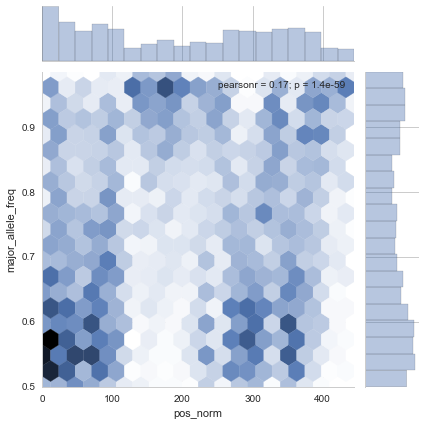

In [805]:
sns.jointplot(x='pos_norm', y='major_allele_freq', data=features, kind='hex');

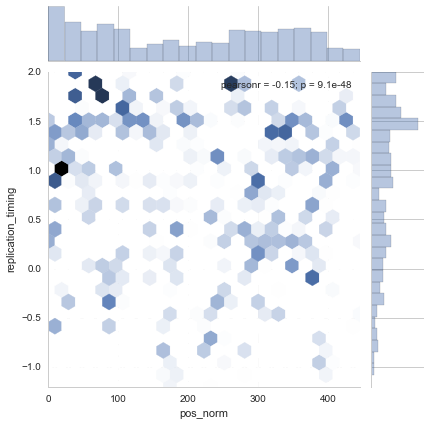

In [814]:
sns.jointplot(x='pos_norm', y='replication_timing', data=features, kind='hex');

In [816]:
rt = pd.read_table('/raid3/publicdata/replication_domain_db/RD_sm300_2936763_hFibiPS4p72.hg19.txt',
                   low_memory=False, skiprows=15, index_col=0)
rt = rt[rt.Chromosome == 'chrX']

In [817]:
rt.head()

,Gene_Name,Chromosome,Start_Position,End_Position,Data_Value
ID,,,,,
X2038585,NaN,chrX,1332,1392,0.061929
X2038586,NaN,chrX,6329,6389,0.073831
X2038587,NaN,chrX,7014,7074,0.075423
X2038588,NaN,chrX,10231,10291,0.082775
X2038589,NaN,chrX,11156,11216,0.084851


In [827]:
(rt.Start_Position.max() - rt.Start_Position.min()) / 10000

15490

In [829]:
rt.Start_Position[1000] - rt.Start_Position[0]

2160600

In [ ]:
rt.shape

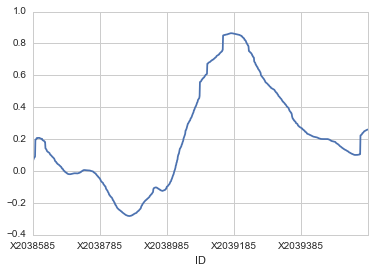

In [821]:
rt.Data_Value.head(1000).plot(kind='bar')

In [831]:
t.head()

id,071ca248-bcb1-484d-bff2-3aefc84f8688,b2752f67-e17e-41c3-b1ee-99b3349ab3e2,a7bd3a9d-ec37-4ed9-829f-8a45ca5bd1de,a7ae77bf-dac8-47c4-a2b0-866ce927bc30,a0f3cb0e-8712-476c-8560-346c98044b19,9f7b4aa4-f7b3-4ba6-b3e6-75c24617d949,9e5035d3-9ced-4b81-b77b-87d6aaf2631d,9dea3b37-fc47-42f1-a7bc-1af671af5693,9cf76144-f3fc-464b-a4aa-8b716fe3ee39,9c9a5b94-60b2-4fa2-988b-60be7c7b1a25,...,57c37aff-2224-4314-a337-454fb82ef47b,574442f2-baca-4800-ad09-fed27ea4bd87,51ada403-952c-43c1-b0ec-12052cb4e747,5093c812-a4da-47d2-a61e-cc4bb7609c4c,563598a4-1956-4303-9c84-fbc9e4fdb510,45c8234a-0cf0-4706-8dde-5f0cb7c38f3d,4436214a-6437-4a8f-b7c0-cb7299791d93,42beae13-e272-460e-bee8-d9c187a6acaf,3e439747-107e-41c2-9455-a28a20dcf5ce,40584e9f-7f57-46b8-b006-dec1fe6cf9ea
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000102081.9,NaN,NaN,NaN,0.906863,NaN,NaN,NaN,NaN,0.683203,NaN,...,0.647027,NaN,NaN,NaN,NaN,NaN,NaN,0.906508,0.877983,NaN
ENSG00000071889.12,0.973196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000180182.6,0.666041,NaN,NaN,NaN,0.831703,NaN,0.712688,NaN,0.754124,NaN,...,NaN,0.877169,0.535159,NaN,NaN,0.587391,NaN,0.571805,0.928160,NaN
ENSG00000169057.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.738500,0.901773,...,NaN,NaN,NaN,0.678279,0.620653,NaN,0.935533,0.594343,NaN,NaN
ENSG00000077274.7,NaN,NaN,0.652614,NaN,NaN,0.510355,NaN,NaN,NaN,NaN,...,0.681294,NaN,0.546858,NaN,0.538789,NaN,NaN,NaN,NaN,NaN


## Reactivation QTLs